
# How-to Guide: Using Conditional Workflows

This guide explains how to create workflows with conditional execution using `when` and `pickValue`. 

These features allow tasks to run conditionally based on inputs and dynamically select outputs.

## Objective

1. Process raster files using `rio_stack` if the EPSG code is `"native"`.
2. Use `rio_warp_stack` if the EPSG code is not `"native"`.
3. Dynamically choose the appropriate output using `pickValue: the_only_non_null`.

## Key Features

1. Conditional Execution with `when`

The `when` field controls whether a step is executed based on an input condition.

In [1]:
cwl_file="../cwl/08-conditional-workflows/conditional-workflows.cwl"

yq '.. | select(has("when")) | {"when": .when}' $cwl_file


when: $( inputs.epsg_code == "native")
when: $( inputs.epsg_code != "native")


* Executes the step only if the condition evaluates to true.

2. Dynamic Output Selection with `pickValue`

The `pickValue` field determines how to handle multiple output sources.

In [2]:
yq '.. | select(has("pickValue")) | {"pickValue": .pickValue}' $cwl_file

pickValue: the_only_non_null
pickValue: the_only_non_null


* Selects the only non-null value from the list of outputs.
* Ensures only one output is passed downstream.

## Steps

1. Define the Workflow

**Workflow Inputs and Outputs**

The workflow accepts:

* `stac-item`: A STAC item URL.
* `epsg_code`: EPSG code for projection (`default: "native"`).
* `bands`: An array of band names (e.g., `["red", "green", "blue"]`).

**Workflow Definition**

In [3]:
yq '.' $cwl_file

cwlVersion: v1.2
$graph:
  - class: Workflow
    id: main
    requirements:
      InlineJavascriptRequirement: {}
      NetworkAccess:
        networkAccess: true
      ScatterFeatureRequirement: {}
      MultipleInputFeatureRequirement: {}
    inputs:
      stac-item:
        type: string
      epsg_code:
        type: string
        default: "native"
      bands:
        type: string[]
    outputs:
      rgb-tif:
        outputSource: step_color/rgb
        type: File
      stack:
        outputSource:
          - step_stack/stacked
          - step_warp_stack/stacked
        pickValue: the_only_non_null
        type: File
    steps:
      step_curl:
        in:
          stac_item: stac-item
          common_band_name: bands
        out:
          - hrefs
        run: "#stac"
        scatter: common_band_name
        scatterMethod: dotproduct
      step_stack:
        in:
          tiffs:
            source: step_curl/hrefs
          epsg_code: epsg_code
        out:
          - sta

Its graphical representation:


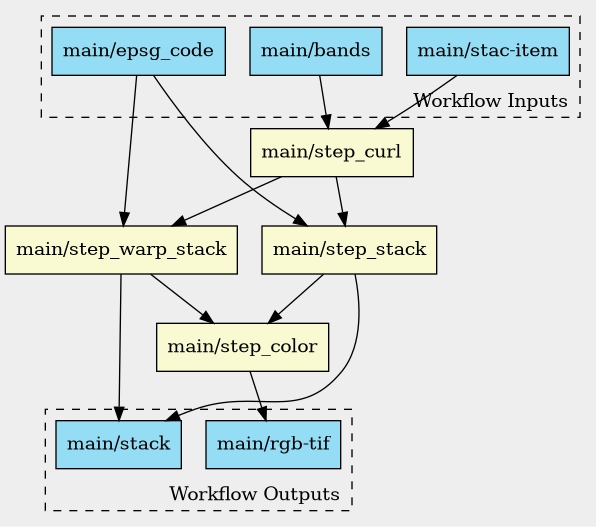

In [4]:
cwltool --print-dot $cwl_file 2> /dev/null | dot -Tpng | display

2. Conditional Steps

Step 1: Use `rio_stack` for Native EPSG

In [7]:
yq '.. | select(has("step_stack")) | {"step_stack": .step_stack}' $cwl_file

step_stack:
  in:
    tiffs:
      source: step_curl/hrefs
    epsg_code: epsg_code
  out:
    - stacked
  run: "#rio_stack"
  when: $( inputs.epsg_code == "native")


* Executes only if epsg_code == "native".

Step 2: Use `rio_warp_stack` for Reprojection

In [8]:
yq '.. | select(has("step_warp_stack")) | {"step_warp_stack": .step_warp_stack}' $cwl_file

step_warp_stack:
  in:
    tiffs:
      source: step_curl/hrefs
    epsg_code: epsg_code
  out:
    - stacked
  run: "#rio_warp_stack"
  when: $( inputs.epsg_code != "native")


* Executes only if epsg_code != "native".

3. Dynamic Output Selection

Stack Selection


In [9]:
yq '.. | select(has("stack")) | {"stack": .stack}' $cwl_file

stack:
  outputSource:
    - step_stack/stacked
    - step_warp_stack/stacked
  pickValue: the_only_non_null
  type: File


* Dynamically selects the output from `step_stack` or `step_warp_stack`.
* Ensures the downstream step (`step_color`) receives the correct output.

4. Run the Workflow

Run the workflow with the following commands based on the desired EPSG code:

Native EPSG Code:

```bash
cwltool conditional-workflows.cwl \
    --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A  \
    --bands red \
    --bands green \
    --bands blue \
    --epsg_code native
```

In [10]:
cwltool ../cwl/08-conditional-workflows/conditional-workflows.cwl --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A  --bands red --bands green --bands blue > output.json

INFO /home/fbrito/.local/bin/cwltool 3.1.20240508115724
INFO Resolved '../cwl/08-conditional-workflows/conditional-workflows.cwl' to 'file:///data/work/github/eoepca-plus/how-to/cwl/08-conditional-workflows/conditional-workflows.cwl'
INFO [workflow ] start
INFO [workflow ] starting step step_curl
INFO [step step_curl] start
INFO [job step_curl] /tmp/3y46hcxg$ docker \
    run \
    -i \
    --mount=type=bind,source=/tmp/3y46hcxg,target=/meIwCJ \
    --mount=type=bind,source=/tmp/9cp3c_zk,target=/tmp \
    --workdir=/meIwCJ \
    --read-only=true \
    --log-driver=none \
    --user=1000:1000 \
    --rm \
    --cidfile=/tmp/rl90ik3b/20241230141618-659164.cid \
    --env=TMPDIR=/tmp \
    --env=HOME=/meIwCJ \
    docker.io/curlimages/curl:latest \
    curl \
    https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A > /tmp/3y46hcxg/message
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                   

Reprojected EPSG Code

```bash
cwltool conditional-workflows.cwl \
    --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A  \
    --bands red \
    --bands green \
    --bands blue \
    --epsg_code "EPSG:4326"
```

5. Expected Output

Intermediate Outputs:
* `stacked` file from either `step_stack` or `step_warp_stack`.

Final Output:
* `rgb-tif`: RGB composite file produced by `step_color`.

In [11]:
cat output.json | yq e . -o=json

{
  "rgb-tif": {
    "location": "file:///data/work/github/eoepca-plus/how-to/docs/rgb.tif",
    "basename": "rgb.tif",
    "class": "File",
    "checksum": "sha1$e18f83a555f6ecf55ab1719b31a59f00c185f433",
    "size": 361747464,
    "path": "/data/work/github/eoepca-plus/how-to/docs/rgb.tif"
  },
  "stack": {
    "location": "file:///data/work/github/eoepca-plus/how-to/docs/stacked.tif",
    "basename": "stacked.tif",
    "class": "File",
    "checksum": "sha1$a9fcfcac28c669f3714eaa4cc59858a28f1e715b",
    "size": 723450636,
    "path": "/data/work/github/eoepca-plus/how-to/docs/stacked.tif"
  }
}


## Key Takeaways

Conditional Steps:

* Use `when` to execute steps based on input conditions.
* Allows workflows to adapt to varying requirements dynamically.

Dynamic Output Handling:

* Use `pickValue` to select the appropriate output among multiple sources.

Flexible Workflows:

* This approach creates workflows that handle both native and reprojected data seamlessly.

This guide demonstrates how to build adaptable workflows in CWL, leveraging conditional execution and dynamic output selection.
